In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:.3f}'.format
dataset_type = {
    "vtab/clevr_closest_object_distance": "structured",
    "vtab/flowers": "natural",
    "cars": "natural",
    "vtab/svhn": "natural",
    "vtab/diabetic_retinopathy": "specialized",
    "vtab/smallnorb_label_elevation": "structured",
    "vtab/dmlab": "structured",
    "fer2013": "natural",
    "renderedsst2": "natural",
    "mnist": "natural",
    "vtab/pets": "natural",
    "vtab/caltech101": "natural",
    "vtab/kitti_closest_vehicle_distance": "structured",
    "vtab/cifar100": "natural",
    "voc2007_multilabel": "natural",
    "vtab/dsprites_label_x_position": "structured",
    "imagenet1k": "natural",
    "voc2007": "natural",
    "sun397": "natural",
    "vtab/smallnorb_label_azimuth": "structured",
    "fgvc_aircraft": "natural",
    "country211": "natural",
    "vtab/cifar10": "natural",
    "vtab/dtd": "natural",
    "vtab/eurosat": "specialized",
    "stl10": "natural",
    "vtab/resisc45": "specialized",
    "vtab/pcam": "specialized",
    "gtsrb": "natural",
    "vtab/clevr_count_all": "structured",
    "vtab/dsprites_label_orientation": "structured",
}
def extract_arch(model):
    vit, size, patch_size, *rest = model.split("-")
    return vit+"-"+size+"-"+patch_size


In [167]:
df = pd.read_csv("benchmark.csv")
df.loc[:, "dataset_type"] = df.dataset.apply(lambda d:dataset_type[d])
df.loc[:, "model_arch"] = df.model.apply(extract_arch)

# Accuracy of all models on all datasets

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

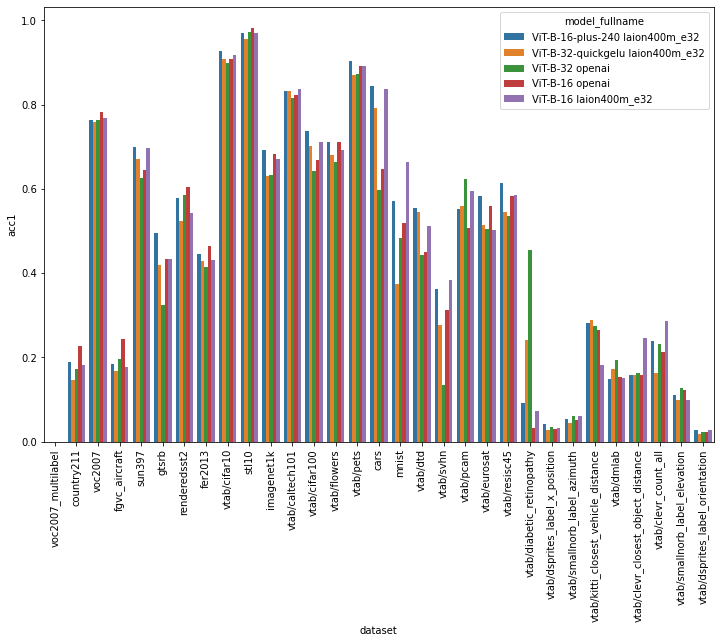

In [168]:
fig = plt.figure(figsize=(12,8))
order = df.sort_values(by="dataset_type").dataset.unique()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Zoomig on specific architecture

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

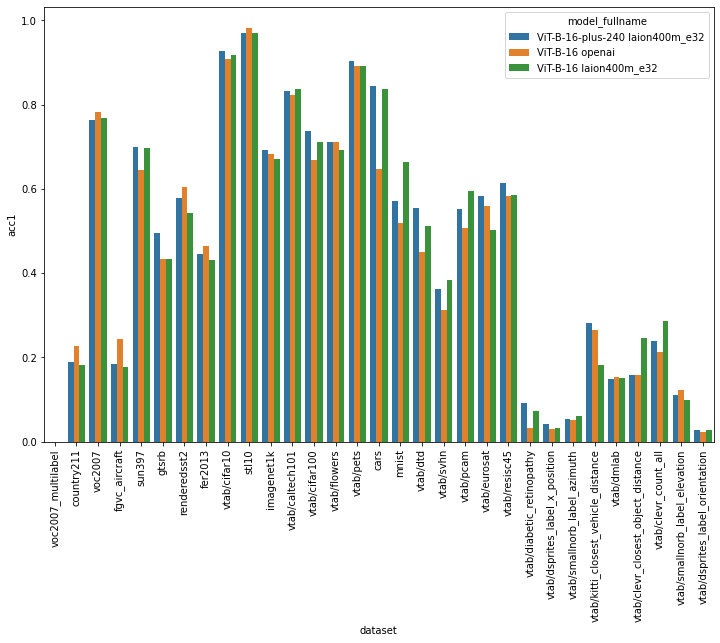

In [172]:

fig = plt.figure(figsize=(12,8))
order = df.sort_values(by="dataset_type").dataset.unique()
d = df[df.model_arch=="ViT-B-16"]
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="model_fullname"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Accuracy averaged over all models for each dataset

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

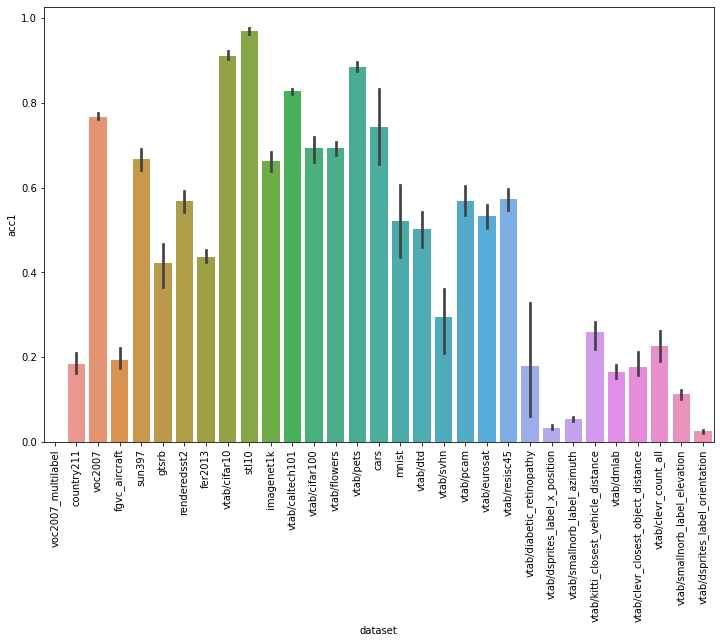

In [169]:
fig = plt.figure(figsize=(12,8))
order = df.sort_values(by="dataset_type").dataset.unique()
ax = sns.barplot(
    x="dataset", y="acc1", data=df,
    order=order
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over architecture for each dataset

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

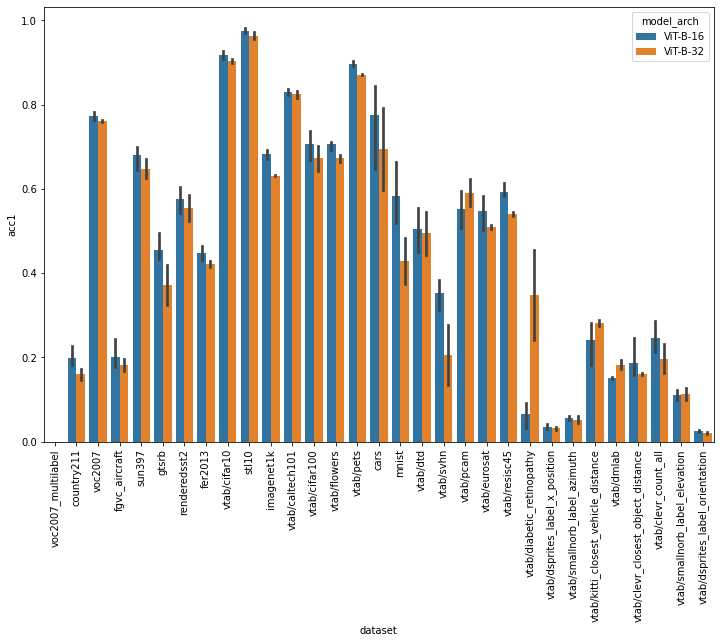

In [170]:
fig = plt.figure(figsize=(12,8))
order = df.sort_values(by="dataset_type").dataset.unique()

ax = sns.barplot(
    x="dataset", y="acc1", 
    data=df,
    order=order,
    hue="model_arch"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Grouping over pre-training data source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

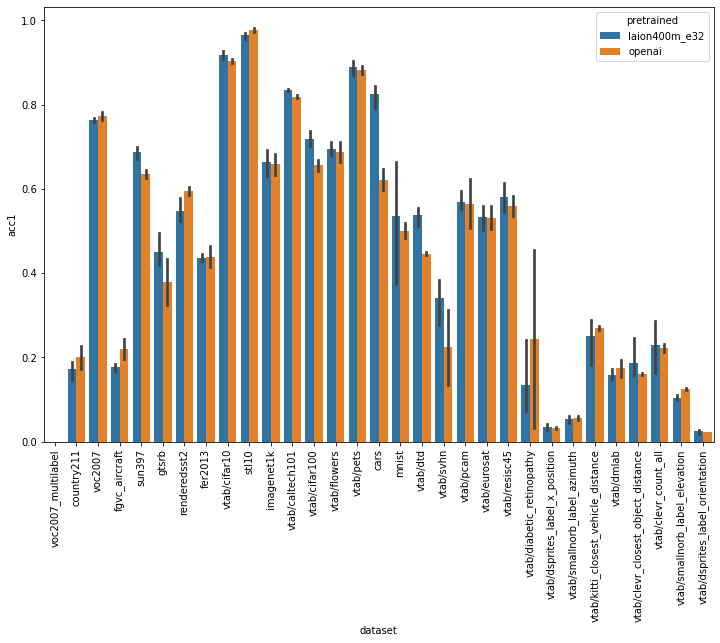

In [161]:
fig = plt.figure(figsize=(12,8))
order = df.sort_values(by="dataset_type").dataset.unique()
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained"
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Best results from each pre-training source

<AxesSubplot:xlabel='dataset', ylabel='acc1'>

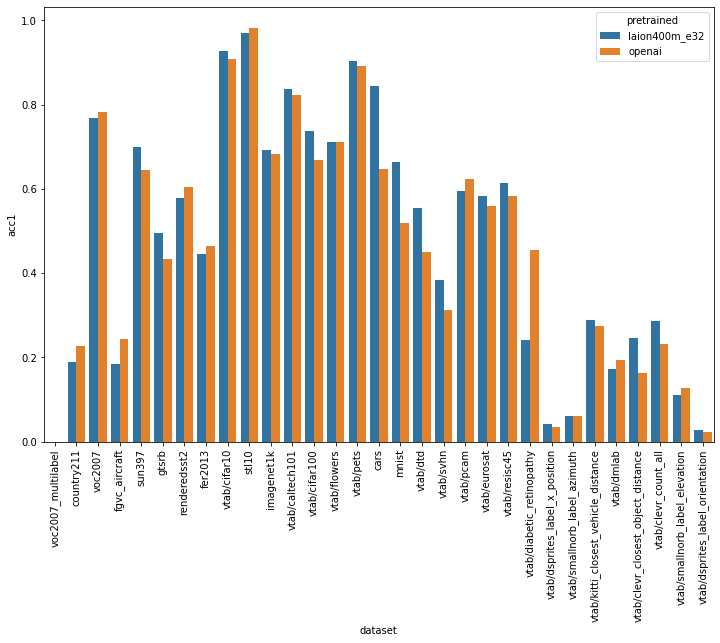

In [178]:
fig = plt.figure(figsize=(12,8))
order = df.sort_values(by="dataset_type").dataset.unique()
d = df.copy()
ax = sns.barplot(
    x="dataset", y="acc1", 
    data=d,
    order=order,
    hue="pretrained",
    estimator=np.max,
    ci=None
)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax

# Detailed results

In [179]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32
dataset,,,,,
cars,0.837,0.647,0.845,0.596,0.793
country211,0.181,0.228,0.189,0.172,0.148
fer2013,0.432,0.463,0.445,0.414,0.430
fgvc_aircraft,0.177,0.243,0.185,0.196,0.167
gtsrb,0.435,0.433,0.494,0.326,0.420
imagenet1k,0.670,0.683,0.692,0.633,0.629
mnist,0.663,0.518,0.570,0.482,0.374
renderedsst2,0.544,0.605,0.579,0.586,0.523
stl10,0.970,0.983,0.970,0.971,0.956


In [150]:
metric = "mean_per_class_recall"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32
dataset,,,,,
cars,0.838,0.647,0.845,0.597,0.795
country211,0.181,0.228,0.189,0.172,0.148
fer2013,0.391,0.418,0.395,0.364,0.398
fgvc_aircraft,0.177,0.242,0.185,0.196,0.167
gtsrb,0.404,0.364,0.430,0.305,0.389
imagenet1k,0.670,0.683,0.692,0.633,0.629
mnist,0.664,0.523,0.570,0.476,0.364
renderedsst2,0.543,0.605,0.580,0.586,0.523
stl10,0.970,0.983,0.970,0.971,0.956


In [190]:
# For multi-label classification tasks
metric = "mean_average_precision"
pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()

model_fullname,ViT-B-16 laion400m_e32,ViT-B-16 openai,ViT-B-16-plus-240 laion400m_e32,ViT-B-32 openai,ViT-B-32-quickgelu laion400m_e32
dataset,,,,,
voc2007_multilabel,0.784,0.789,0.784,0.760,0.763


## Aggregating over datasets

See VTAB (https://arxiv.org/pdf/1910.04867.pdf, Section E) for a discussion about different aggregation 
strategies and how much they correlate. They find that all aggregation strategies have high
Kendall score with the simple top-1 mean accuracy over datasets.

### Ranking the models over mean top-1 accuracy over all datasets

In [192]:
df.groupby("model_fullname").agg(['mean', 'std', 'median']).sort_values(by=("acc1", "mean"), ascending=False)

acc1               acc5               \
                                  mean   std median  mean   std median   
model_fullname                                                           
ViT-B-16-plus-240 laion400m_e32  0.479 0.299  0.554 0.773 0.268  0.872   
ViT-B-16 laion400m_e32           0.472 0.297  0.508 0.775 0.265  0.899   
ViT-B-16 openai                  0.456 0.289  0.485 0.775 0.253  0.869   
ViT-B-32-quickgelu laion400m_e32 0.451 0.288  0.472 0.761 0.271  0.877   
ViT-B-32 openai                  0.449 0.276  0.469 0.766 0.257  0.868   

                                 mean_per_class_recall               \
                                                  mean   std median   
model_fullname                                                        
ViT-B-16-plus-240 laion400m_e32                  0.489 0.297  0.554   
ViT-B-16 laion400m_e32                           0.478 0.295  0.513   
ViT-B-16 openai                                  0.467 0.284  0.478   
ViT-B-32-quickgelu laion400m_e32                 0.454 0.292  0.460   
ViT-B-32 openai                                  0.445 0.283  0.460   

                                 mean_average_precision             
                                                   mean std median  
model_fullname                                                      
ViT-B-16-plus-240 laion400m_e32                   0.784 nan  0.784  
ViT-B-16 laion400m_e32                            0.784 nan  0.784  
ViT-B-16 openai                                   0.789 nan  0.789  
ViT-B-32-quickgelu laion400m_e32                  0.763 nan  0.763  
ViT-B-32 openai                                   0.760 nan  0.760

### Compute rank of the model for each dataset (1 = best, lower is better), then average the ranks over the datasets

In [213]:
metric = "acc1"
df_metric = pd.pivot(df, index="model_fullname", columns="dataset", values=metric).T.dropna()
df_metric.rank(axis=1,ascending=False).agg(["mean", "std"]).T.sort_values(by="mean",ascending=True)

,mean,std
ViT-B-16-plus-240 laion400m_e32,2.167,1.147
ViT-B-16 laion400m_e32,2.567,1.194
ViT-B-16 openai,2.967,1.351
ViT-B-32 openai,3.400,1.545
ViT-B-32-quickgelu laion400m_e32,3.900,1.213
